In [6]:
def normalize(df):
    import pandas as pd
    from sklearn import preprocessing
    try:
        x = df.drop('LIFE_EXPECTANCY',axis=1).values #returns a numpy array
    except:
        x = df
        
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df1 = pd.DataFrame(x_scaled)
    
    try:
        df1['LIFE_EXPECTANCY']=df['LIFE_EXPECTANCY']
    except: pass
    return df1
    

def insert_into_table(conn, df, tablename):
    curr = conn.cursor()
    try:
        

        command = f"""INSERT INTO {tablename} (""" 
        final_part =''

        for idx in df.columns:
            command = command + idx + ', '
            final_part = final_part +'%s,'

        command = command[:-2] + ') VALUES(' + final_part[:-1] + ')'

        insert_into_videos = (command)


        for i, row in df.iterrows():
            row_to_insert = []

            for column in df.columns:
                row_to_insert = row_to_insert + [row[column]]

            curr.execute(insert_into_videos, row_to_insert)
            
    except Exception as e:
        print(f'FALHA NO PREENCHIMENTO DA TABELA: {e}')
        curr.execute("ROLLBACK")
    conn.commit()
    

    
def create_table(df, tablename,  conn):
    
    command = f"""CREATE TABLE {tablename} ( """

    for idx in df.columns:
        command = command+idx+' '
        if pd.api.types.is_integer_dtype(df[idx]):
            command = command+'INT,'
        elif pd.api.types.is_float_dtype(df[idx]):
            command = command+'FLOAT,'
        else:
            command = command+'VARCHAR,'
    command = command[:-1]        
    command = command + ' )'
    
    
    curr = conn.cursor()
    try:
        curr.execute(f'DROP TABLE IF EXISTS {tablename}')
        create_table_command = (command)

        curr.execute(create_table_command)
    except Exception as e:
        print(f'FALHA NA CRIAÇÃO DA TABELA: {e}')
        curr.execute("ROLLBACK")
    conn.commit()
    
    insert_into_table(conn, df,tablename)

In [7]:
from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
 
def reg_lin(df, list_country,year):
    try:
        df.drop('COUNTRY_NAME',axis=1,inplace=True)
    except: pass
    df1=df
    df.dropna(inplace=True)
    
    df_test=df[df['YEAR']>year]
    df = df[df['YEAR']<year+1]
    
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    ## Assign the predictor and response to variables. To fit the data, the pandas dataframe must be converted into a numpy
    ## array in a matricial shape, even if with a single column
    X_df = df.drop(columns = 'LIFE_EXPECTANCY')
    X = X_df.values
    y = df['LIFE_EXPECTANCY'].values.reshape(-1, 1)
    
    
    X_df_test = df_test.drop(columns = 'LIFE_EXPECTANCY')
    X_test = X_df_test.values
    y_test = df_test['LIFE_EXPECTANCY'].values.reshape(-1, 1)
    

    ## Initialize the model as a LinearRegression() function, and fit the data to it
    regr = LinearRegression()
    regr.fit(X, y)

    ## Format and print the interception and coefficients
    values = list(regr.coef_[0])
    values.insert(0, regr.intercept_[0])
    names = list(X_df.columns.values)
    names.insert(0,'intrcpt')
    s = ['{} :: {:.9f}'.format(names[i].rjust(7), values[i]) for i in range(len(values))]
    listToStr = '\n'.join([str(elem) for elem in s]) 
    print(listToStr)  

    ## To calculate the R^2 score, the prediction of medv is calculate using the predict method.
    medv_pred = regr.predict(X_test)
    
    mse = mean_squared_error(medv_pred,y_test)
    r2_value = r2_score(y_test, medv_pred)
    print('\n{} :: {:.4f}'.format('R^2'.rjust(7), r2_value))

 
    df_results = df_test
    df_results['predict'] = medv_pred

    
    
    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['COUNTRY_NAME_'+country]==1]
        # plot lines
        plt.plot(df_plot['YEAR'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['COUNTRY_NAME_'+country]==1]['YEAR'].values, df1[df1['COUNTRY_NAME_'+country]==1]['LIFE_EXPECTANCY'].values, label = "real")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "training")
        plt.title(country + ' Linear Regression')
        plt.xlabel('year')
        plt.ylabel('life expectancy')
        plt.legend()
        plt.show()
        
        c_not_delete_countries += ['COUNTRY_NAME_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['YEAR']
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=mse
    df_results['R2']=r2_value
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['YEAR']+['LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Linear Regression'

    
    return result

    
    
    
def ridge(df,list_country,year):
    import numpy as np
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import KFold
    from sklearn import metrics

    df1=df
    
    X_train = df[df['YEAR']<year+1].drop('LIFE_EXPECTANCY',axis=1).values
    
    X_test = df[df['YEAR']>year].drop('LIFE_EXPECTANCY',axis=1).values
    
    y_train = df[df['YEAR']<year+1]['LIFE_EXPECTANCY'].values
    
    y_test = df[df['YEAR']>year]['LIFE_EXPECTANCY'].values
    
    

    values_ridge = pd.DataFrame(columns=['alpha', 'mse'])
    alphas = [10**i for i in np.linspace(start = -2, stop = 10, num = 100).tolist()]
    count = 0
    iter_count = 1
    
    best_mse=100000
    best_r2=0
    best_alpha=0
    for alpha in alphas:
        
        clf = Ridge(alpha=alpha)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        mse = metrics.mean_squared_error(y_pred,y_test)
        r2 = r2_score(y_pred,y_test)
        
        values_ridge.loc[count] = [alpha, mse]
        #values_ridge.loc[count] = [alpha, r2]
        count += 1
        
        
        if mse<best_mse:
            best_mse=mse
            best_alpha=alpha
            clf_best=clf
            y_pred_best = y_pred
            

        '''if r2>best_r2:
            best_r2=r2
            best_alpha=alpha
        '''

    plt.plot(values_ridge.alpha, values_ridge.mse, 'r.', label = 'Fold\'s MSE')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    #plt.plot(values_ridge2.alpha, values_ridge2.mse, 'k', linewidth=5.0, label = 'Mean MSE per Alpha')
    #plt.plot(values_ridge3.alpha, values_ridge3.mse, 'b', linewidth=5.0, label = 'Median MSE per Alpha')
    #plt.xscale('log')
    plt.title('Ridge Regression Study')
    plt.legend()
    plt.show()

    print('best mse:',best_mse,'best alfa:',best_alpha,'\n')
    #print('best r2:',r2,'best alfa:',best_alpha)
    
    
    
    
    clf = Ridge(alpha=best_alpha)
    clf.fit(X_train, y_train)
    
     ## Format and print the interception and coefficients
    values = list(clf_best.coef_)
    values.insert(0, clf.intercept_)
    names = list(df.columns.values)
    names.insert(0,'intrcpt')
    s = ['{} :: {:.9f}'.format(names[i].rjust(7), values[i]) for i in range(len(values))]
    listToStr = '\n'.join([str(elem) for elem in s]) 
    print(listToStr)  

 
    r2 = r2_score(y_pred_best,y_test)
     
    
    
    print('R2:',r2)

    
    df_results = df[df['YEAR']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['COUNTRY_NAME_'+country]==1]
        # plot lines
        plt.plot(df_plot['YEAR'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['COUNTRY_NAME_'+country]==1]['YEAR'].values, df1[df1['COUNTRY_NAME_'+country]==1]['LIFE_EXPECTANCY'].values, label = "real")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "training")
        plt.title(country+' Ridge Regression')
        plt.xlabel('year')
        plt.ylabel('life expectancy')
        plt.legend()
        plt.show()
    
        c_not_delete_countries += ['COUNTRY_NAME_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['YEAR']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['YEAR']+['LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Ridge Regression'
    
    return result
    
    
    
    
def lasso(df, list_country,year):
    import numpy as np
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import KFold
    from sklearn import metrics
    
    df1=df

    X_train = df[df['YEAR']<year+1].drop('LIFE_EXPECTANCY',axis=1).values
    
    X_test = df[df['YEAR']>year].drop('LIFE_EXPECTANCY',axis=1).values
    
    y_train = df[df['YEAR']<year+1]['LIFE_EXPECTANCY'].values
    
    y_test = df[df['YEAR']>year]['LIFE_EXPECTANCY'].values

    values_ridge = pd.DataFrame(columns=['alpha', 'mse'])
    alphas = [10**i for i in np.linspace(start = -2, stop = 10, num = 100).tolist()]
    count = 0
    iter_count = 1
    
    best_mse=100000
    best_r2=0
    best_alpha=0

    for alpha in alphas:
 
        clf = Lasso(alpha=alpha, max_iter = 20000)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        mse = metrics.mean_squared_error(y_pred,y_test)

        values_ridge.loc[count] = [alpha, mse]
        count += 1
        
        
        if mse<best_mse:
            
            best_mse = mse
            best_alpha = alpha
            y_pred_best = y_pred
            clf_best=clf
 
    
 
    print('best mse:',best_mse,'best alfa:',best_alpha,'\n')
    #print('best r2:',r2,'best alfa:',best_alpha)
     
 

    plt.plot(values_ridge.alpha, values_ridge.mse, 'r.', label = 'Fold\'s MSE') 
    plt.title('Lasso Regression Study')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.xscale('log')
    plt.legend()
    plt.show()
    

    ## Format and print the interception and coefficients
    values = list(clf_best.coef_)
    values.insert(0, clf.intercept_)
    names = list(df.columns.values)
    names.insert(0,'intrcpt')
    s = ['{} :: {:.9f}'.format(names[i].rjust(7), values[i]) for i in range(len(values))]
    listToStr = '\n'.join([str(elem) for elem in s]) 
    print(listToStr)  
    
    r2=r2_score(y_test,y_pred_best)
    print('R2:',r2)
    
    df_results = df[df['YEAR']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['COUNTRY_NAME_'+country]==1]
        # plot lines
        plt.plot(df_plot['YEAR'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['COUNTRY_NAME_'+country]==1]['YEAR'].values, df1[df1['COUNTRY_NAME_'+country]==1]['LIFE_EXPECTANCY'].values, label = "real")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "training")
        
        plt.legend()
        plt.title(country+' Lasso Regression')
        plt.xlabel('year')
        plt.ylabel('life expectancy')
        plt.show()
        c_not_delete_countries += ['COUNTRY_NAME_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['YEAR']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['YEAR']+['LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Lasso Regression'
    
    return result

def decision_tree(df,list_country,year):
    from sklearn.tree import DecisionTreeRegressor
    
    
    df1=df
    

    X_train = df[df['YEAR']<year+1].drop('LIFE_EXPECTANCY',axis=1)
    
    X_test = df[df['YEAR']>year].drop('LIFE_EXPECTANCY',axis=1) 
    
    y_train = df[df['YEAR']<year+1]['LIFE_EXPECTANCY'] 
    
    y_test = df[df['YEAR']>year]['LIFE_EXPECTANCY'] 
    
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    count = 0
    iter_count = 1
    best_mse=1000000
    
    
    
    
    
    
    
    

#     from sklearn.model_selection import GridSearchCV

#     param_grid = {
#         "max_depth": [3,5,10,15,20,None],
#         "min_samples_split": [2,5,7,10],
#         "min_samples_leaf": [1,2,5]
#     }

#     clf = DecisionTreeRegressor(random_state=42)
#     grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_train, y_train)

#     print("Param for GS", grid_cv.best_params_)
#     print("CV score for GS", grid_cv.best_score_)
#     print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train)))
#     print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test)))
    
    
    
    
    
    
    
    
    for i in range(1,100):
        clf = DecisionTreeRegressor(max_depth = i,min_samples_leaf= 1, min_samples_split= 2)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        values_ridge.loc[count] = [i, mse]
        count += 1
        
        if mse<best_mse:
            
            best_mse = mse
            best_max_depth = i
            y_pred_best = y_pred
            clf_best=clf
            
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label = 'Fold\'s MSE') 
    #plt.xscale('log')
    plt.title('Decision Tree Study')
    plt.xlabel('max depth')
    plt.ylabel('mse')
    plt.legend()
    plt.show()
    
    
#     export_graphviz(clf, 
#                 out_file = "tree.dot", 
#                 feature_names = X_train.columns)

#     with open("tree.dot") as f:
#         dot_graph = f.read()
#     plt.figure()
#     graphviz.Source(dot_graph)
#     display(dot_graph)


    print(f'best tree: max_depth = {best_max_depth}')
    r2=r2_score(y_test,y_pred_best)
    print('R2:',r2)
    
    df_results = df[df['YEAR']>year]
    df_results['predict'] = y_pred_best
    
    
    df =df1

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['COUNTRY_NAME_'+country]==1]
        # plot lines
        plt.plot(df_plot['YEAR'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['COUNTRY_NAME_'+country]==1]['YEAR'].values, df1[df1['COUNTRY_NAME_'+country]==1]['LIFE_EXPECTANCY'].values, label = "real")
        plt.plot(X_train[X_train['COUNTRY_NAME_'+country]==1]['YEAR'].values, clf_best.predict(X_train), label = "training")
        
        plt.legend()
        plt.title(country+' Decision Tree')
        plt.xlabel('year')
        plt.ylabel('life expectancy')
        plt.show()
        
        c_not_delete_countries += ['COUNTRY_NAME_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['YEAR']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['YEAR']+['LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Decision Tree'
    
    return result
        

def random_forest(df,list_country,year):
    df1=df

    X_train = df[df['YEAR']<year+1].drop('LIFE_EXPECTANCY',axis=1)
    
    X_test = df[df['YEAR']>year].drop('LIFE_EXPECTANCY',axis=1).values
    
    y_train = df[df['YEAR']<year+1]['LIFE_EXPECTANCY'].values
    
    y_test = df[df['YEAR']>year]['LIFE_EXPECTANCY'].values
 
    
    
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    count = 0
    iter_count = 1
    best_mse=1000000
    
    
    
    
    for i in range(5,len(df1.columns)):
        # Random forests: using 6 features
        clf = RandomForestRegressor(max_features = i, random_state = 1)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        mse=mean_squared_error(y_test, y_pred)
        
        values_ridge.loc[count] = [i, mse]
        count += 1
        
        if mse<best_mse:
            
            best_mse = mse
            best_max_features = i
            y_pred_best = y_pred
            clf_best=clf
            
    print(f'best tree: max_features = {best_max_features}')
    print('mse: ',best_mse)
    
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label = 'Fold\'s MSE') 
    #plt.xscale('log')
    plt.title('Random Forest Study')
    plt.xlabel('max features')
    plt.ylabel('mse')
    plt.legend()
    plt.show()
    
    r2=r2_score(y_test,y_pred_best)
    print('R2:', r2)
    
    df_results = df[df['YEAR']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['COUNTRY_NAME_'+country]==1]
        # plot lines
        plt.plot(df_plot['YEAR'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['COUNTRY_NAME_'+country]==1]['YEAR'].values, df1[df1['COUNTRY_NAME_'+country]==1]['LIFE_EXPECTANCY'].values, label = "real")
        plt.plot(X_train[X_train['COUNTRY_NAME_'+country]==1]['YEAR'].values, clf_best.predict(X_train), label = "training")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "treino")
        
        plt.legend()
        plt.title(country+' Random Forest')
        plt.xlabel('year')
        plt.ylabel('life expectancy')
        plt.show()
        
        c_not_delete_countries += ['COUNTRY_NAME_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['YEAR']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['YEAR']+['LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Random Forest'
    
    return result
        

def gradient_boosting(df,list_country,year):
    from sklearn.model_selection import GridSearchCV
    df1=df
    X_train = df[df['YEAR']<year+1].drop('LIFE_EXPECTANCY',axis=1)
    
    X_test = df[df['YEAR']>year].drop('LIFE_EXPECTANCY',axis=1)
    
    y_train = df[df['YEAR']<year+1]['LIFE_EXPECTANCY'].values
    
    y_test = df[df['YEAR']>year]['LIFE_EXPECTANCY'].values
     
        
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    count = 0
    iter_count = 1
    best_mse=1000000
    
    for learning_rate in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5,0.8,1,1.2,1.4,1.6,1.8]:

        clf = GradientBoostingRegressor(n_estimators = 500, 
                                               learning_rate = learning_rate, 
                                               max_depth = 10, 
                                               random_state = 1)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        values_ridge.loc[count] = [learning_rate, mse]
        count += 1
        
        if mse<best_mse:
            
            best_mse = mse
            best_lr = learning_rate
            y_pred_best = y_pred
            clf_best=clf
        
    print(f'best GB: learning rate = {best_lr}')    
    
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label = 'Fold\'s MSE') 
    #plt.xscale('log')
    plt.title('Gradient Boosting Study')
    plt.xlabel('max features')
    plt.ylabel('mse')
    plt.legend()
    plt.show()
    
    r2 =r2_score(y_test,y_pred_best)
    #return cv_results
    print('R2:',r2)
    
    df_results = df[df['YEAR']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries = []
    for country in list_country:
        df_plot=df_results[df_results['COUNTRY_NAME_'+country]==1]
        # plot lines
        plt.plot(df_plot['YEAR'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['COUNTRY_NAME_'+country]==1]['YEAR'].values, df1[df1['COUNTRY_NAME_'+country]==1]['LIFE_EXPECTANCY'].values, label = "real")
        plt.plot(X_train[X_train['COUNTRY_NAME_'+country]==1]['YEAR'].values, clf_best.predict(X_train), label = "training")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "treino")
        
        plt.legend()
        plt.title(country+' Gradient Boosting')
        plt.xlabel('year')
        plt.ylabel('life expectancy')
        plt.show()
        
        c_not_delete_countries += ['COUNTRY_NAME_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['YEAR']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['YEAR']+['LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Gradient Boosting'
    
    return result

def neural_network(df,list_country,year):    
    from keras.callbacks import ModelCheckpoint
    from keras.models import Sequential
    from keras.layers import Dense, Activation, Flatten
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error 
    
    X_train = df[df['YEAR']<year+1].drop('LIFE_EXPECTANCY',axis=1)
    
    X_test = df[df['YEAR']>year].drop('LIFE_EXPECTANCY',axis=1).values
    
    y_train = df[df['YEAR']<year+1]['LIFE_EXPECTANCY'].values
    
    y_test = df[df['YEAR']>year]['LIFE_EXPECTANCY'].values
    
    #     towardsdatascience.com
    NN_model = Sequential()

    # The Input Layer : 
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    NN_model.summary()
    
    checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]
    
    NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    predictions = NN_model.predict(X_test)
    r2 = r2_score(y_test,predictions)
    
# reg_lin(df, list_country,year)

In [8]:
import pandas as pd
import numpy as np
import psycopg2 as ps
import matplotlib.pyplot as plt

# Connect to PostgreSQL and load final_table
# conn = ps.connect(
#     host='localhost',
#     database='Projeto',
#     user='postgres',
#     password='gi100499',
#     port=5432
# )

# df = pd.read_sql("SELECT * FROM final_table;", conn)
# df = df[df['year'] > 1989]
# df = df[df['year'] < 2017]
# df

df = pd.read_csv('../data/processed/final_table.csv')
df = df[df['YEAR'] > 1989]
df = df[df['YEAR'] < 2017]
df.head()

,COUNTRY_NAME,COUNTRY_CODE,YEAR,LIFE_EXPECTANCY,ADULT_MORTALITY_RATE_PROBABILITY_OF_DYING_BETWEEN_15_AND_60_YEARS_PER_1000_POPULATION,PERCENTAGE_OF_PEOPLE_EXPOSED_TO_AIR_POLLUTION,CO2_EMISSIONS,CPIA_CORRUPTION_IN_THE_PUBLIC_SECTOR_FROM_1_TO_6,DAILY_CALORIC_SUPPLY,OVERWEIGHT_OR_OBESE,...,PEOPLE_SANITATION,DRUG_USE_DISORDERS_y,ALCOHOL_USE_DISORDERS_y,TOBACCO,SUICIDES,SUICIDESMIN,SUICIDESMAX,U5_DEATHS,URBAN_POPULATION,OBESITY_PERCENTAGE
7189,Aruba,ABW,1990,73.468000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31274.0,NaN
7190,Africa Eastern and Southern,AFE,1990,51.154113,NaN,100.0,309980.8254,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75915921.0,NaN
7191,Afghanistan,AFG,1990,50.331000,NaN,100.0,2960.0000,NaN,2314.0,9.1,...,NaN,93.444451,71.935533,9722.539324,NaN,NaN,NaN,110011.0,2628555.0,1.3
7192,Africa Western and Central,AFW,1990,48.816999,NaN,100.0,90210.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63490907.0,NaN
7193,Angola,AGO,1990,45.306000,NaN,100.0,6330.0000,NaN,1641.0,10.3,...,NaN,19.157222,98.430692,5976.776608,NaN,NaN,NaN,124961.0,4400964.0,2.0


In [9]:
# Drop columns that do not have complete data starting from 1990
df.drop([
    'OVERWEIGHT_IN_CHILDREN_AGED_2_TO_4_PERCENTAGE',
    'SUICIDESMIN',
    'SUICIDESMAX',
    'COUNTRY_CODE',
    'PEOPLE_SANITATION',
    'CPIA_CORRUPTION_IN_THE_PUBLIC_SECTOR_FROM_1_TO_6',
    'DAILY_CALORIC_SUPPLY',
    'OVERWEIGHT_OR_OBESE'
], axis=1, inplace=True, errors='ignore')


The result heatmap is:


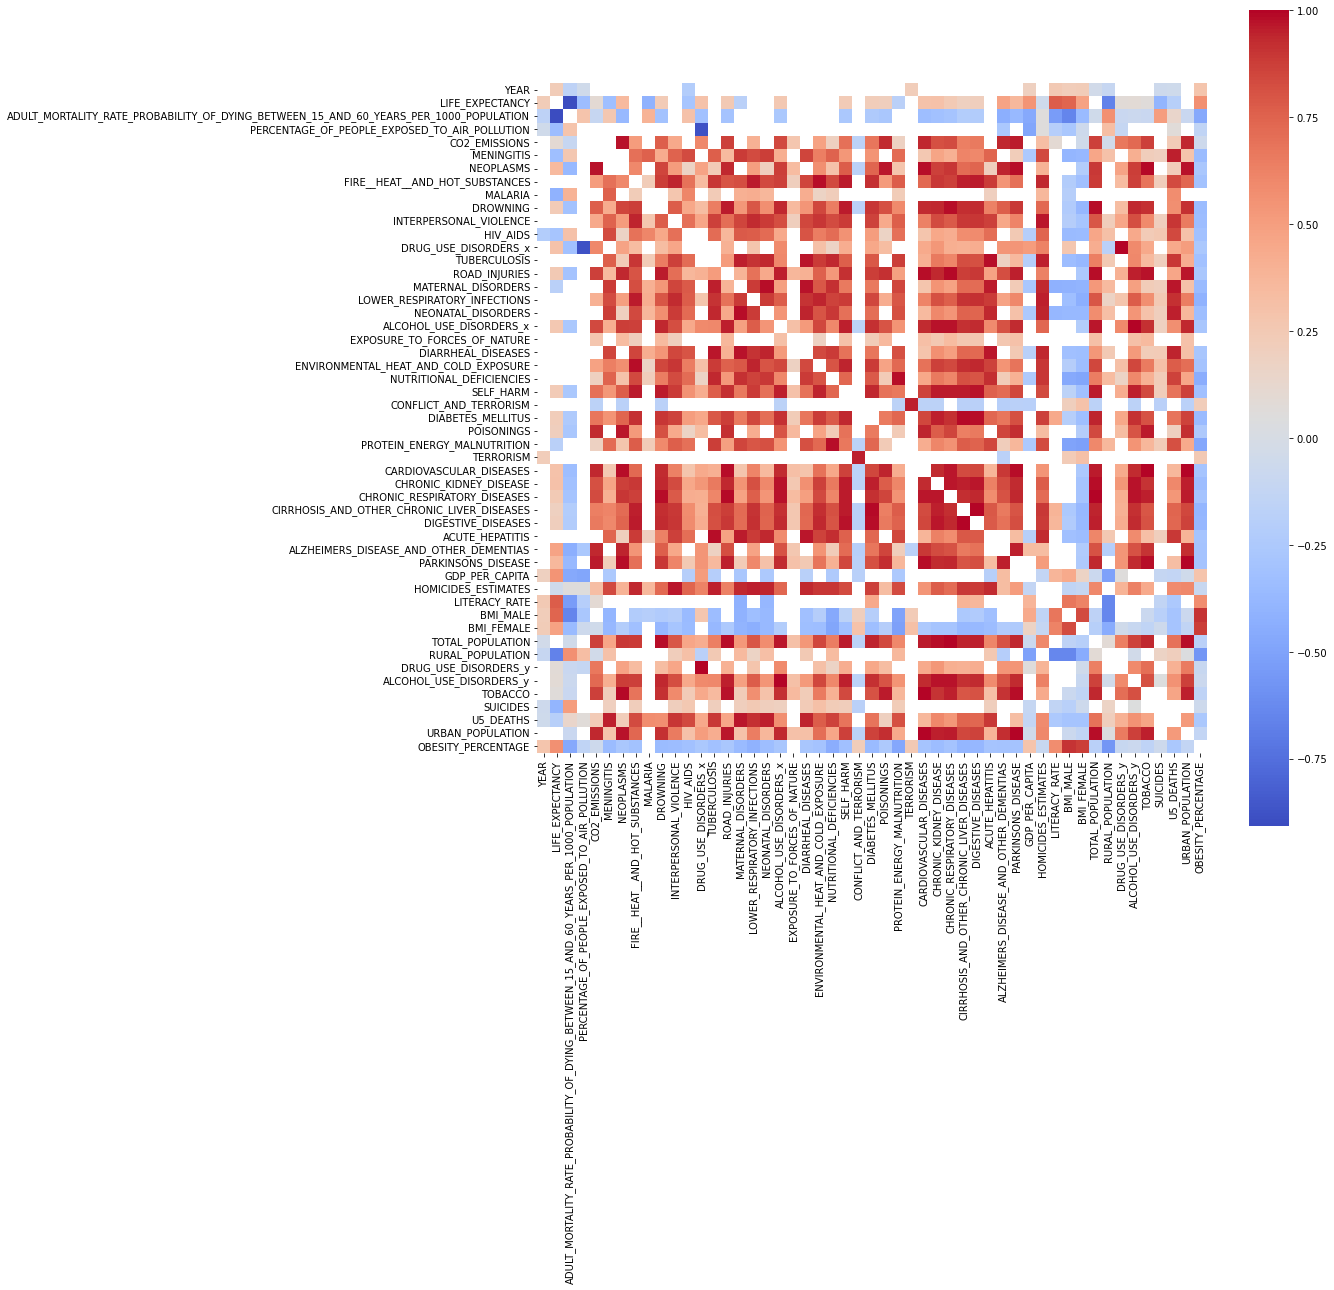

In [10]:
# ---- correlation matrix of the columns (with a statistical significance of 0.1%) and a scatter plot of medv(lstat)
import seaborn as sns
## Import pearsonr function from scipy -- calculate the correlation and p-value between two columns
from scipy.stats import pearsonr

## Calculate the correlations between the columns
df_corrs = df.corr(method='pearson')

## Calculate the p-value, as the second element of the response from the pearsonr function. 
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1])

## Establish the mask, to hide values without a given statistical significance
ptg_stat_sig = 0.1/100
mask = pval > ptg_stat_sig

## Plot the correlation matrix using seaborn's heatmap function
print("The result heatmap is:")
plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(df_corrs, mask = mask, square = True, cmap = 'coolwarm', annot = False)

In [11]:
df = df.drop(['PERCENTAGE_OF_PEOPLE_EXPOSED_TO_AIR_POLLUTION', 'SUICIDES'], axis=1)

intrcpt :: -3475.931012476
   YEAR :: 1.899738178
CO2_EMISSIONS :: -0.000000326
GDP_PER_CAPITA :: 0.000005205
BMI_MALE :: -7.150225778
BMI_FEMALE :: -0.477735364
TOTAL_POPULATION :: -0.000000169
RURAL_POPULATION :: -0.453261284
DRUG_USE_DISORDERS_y :: -0.000217620
ALCOHOL_USE_DISORDERS_y :: 0.000105844
TOBACCO :: -0.000001424
U5_DEATHS :: 0.000012928
URBAN_POPULATION :: -0.000000212
OBESITY_PERCENTAGE :: 0.069321226
COUNTRY_NAME_Brazil :: 0.000000000

    R^2 :: 0.9489


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = medv_pred


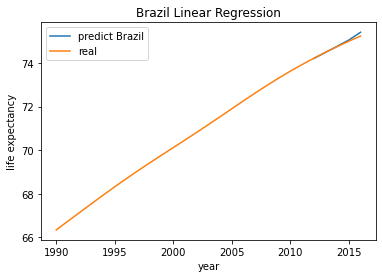

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

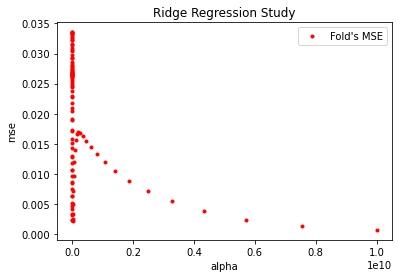

best mse: 0.0007241894994796123 best alfa: 10000000000.0 

intrcpt :: 30.163800360
   YEAR :: 0.000000000
LIFE_EXPECTANCY :: 0.000001454
CO2_EMISSIONS :: 0.000000301
GDP_PER_CAPITA :: 0.000000000
BMI_MALE :: 0.000000000
BMI_FEMALE :: 0.000000392
TOTAL_POPULATION :: 0.000000000
RURAL_POPULATION :: 0.000000011
DRUG_USE_DISORDERS_y :: -0.000000006
ALCOHOL_USE_DISORDERS_y :: 0.000000051
TOBACCO :: 0.000000570
U5_DEATHS :: -0.000000206
URBAN_POPULATION :: 0.000000000
OBESITY_PERCENTAGE :: 0.000000000
R2: 0.9943113882721485


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


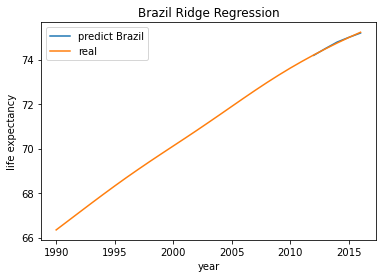

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

best mse: 0.0010887128949352723 best alfa: 305.38555088334186 



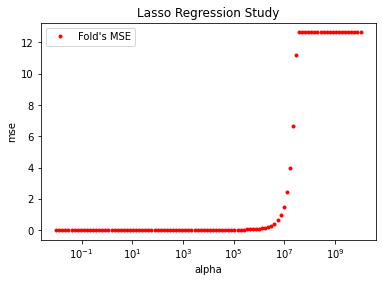

intrcpt :: 71.195108696
   YEAR :: 0.000000000
LIFE_EXPECTANCY :: 0.000001633
CO2_EMISSIONS :: 0.000000000
GDP_PER_CAPITA :: 0.000000000
BMI_MALE :: 0.000000000
BMI_FEMALE :: 0.000000393
TOTAL_POPULATION :: 0.000000000
RURAL_POPULATION :: 0.000000000
DRUG_USE_DISORDERS_y :: -0.000000000
ALCOHOL_USE_DISORDERS_y :: 0.000000000
TOBACCO :: 0.000000000
U5_DEATHS :: -0.000000209
URBAN_POPULATION :: 0.000000000
OBESITY_PERCENTAGE :: 0.000000000
R2: 0.9916554132331509


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


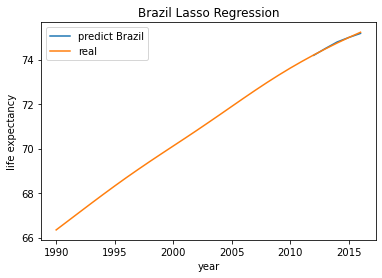

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

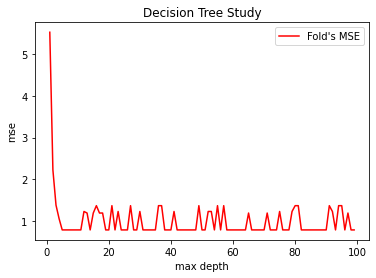

best tree: max_depth = 5
R2: -5.0436779945881245


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


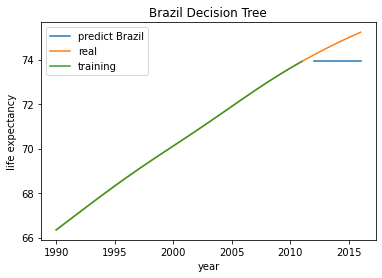

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

best tree: max_features = 10
mse:  0.9552679240398867


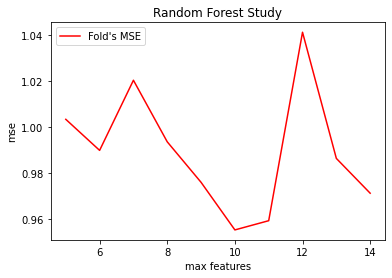

R2: -6.321779795960439


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


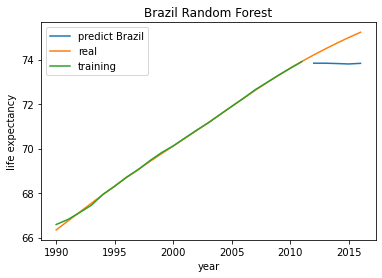

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

best GB: learning rate = 1


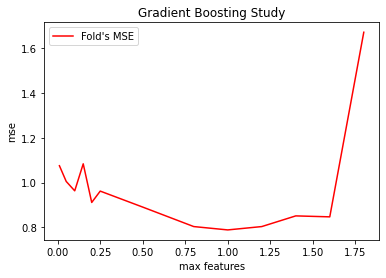

R2: -5.0436779945881245


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:615: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


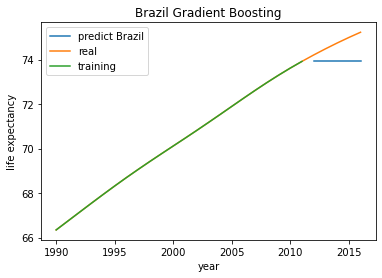

intrcpt :: 8527.188138331
   YEAR :: -4.768137124
CO2_EMISSIONS :: -0.000004271
GDP_PER_CAPITA :: 0.000107678
BMI_MALE :: 119.501744829
BMI_FEMALE :: -97.864864931
TOTAL_POPULATION :: -0.000020822
RURAL_POPULATION :: 17.071126409
DRUG_USE_DISORDERS_y :: 0.003441403
ALCOHOL_USE_DISORDERS_y :: -0.003260928
TOBACCO :: 0.000006529
U5_DEATHS :: -0.000141425
URBAN_POPULATION :: 0.000044390
OBESITY_PERCENTAGE :: 0.225285960
COUNTRY_NAME_South Africa :: 0.000000000

    R^2 :: -4.8520


c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

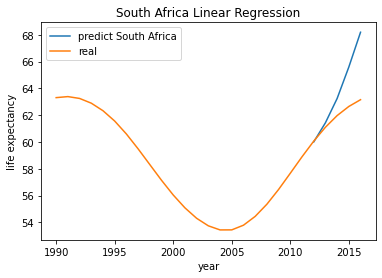

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

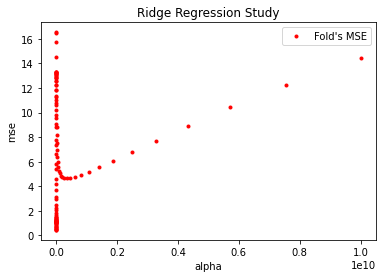

best mse: 0.4509466177966895 best alfa: 533.6699231206312 

intrcpt :: 93.252627985
   YEAR :: -0.000583701
LIFE_EXPECTANCY :: 0.000009013
CO2_EMISSIONS :: 0.000260275
GDP_PER_CAPITA :: 0.000085534
BMI_MALE :: -0.000012436
BMI_FEMALE :: -0.000000836
TOTAL_POPULATION :: -0.000164312
RURAL_POPULATION :: -0.010337230
DRUG_USE_DISORDERS_y :: 0.040164686
ALCOHOL_USE_DISORDERS_y :: -0.000753186
TOBACCO :: -0.000030486
U5_DEATHS :: 0.000000624
URBAN_POPULATION :: -0.000377285
OBESITY_PERCENTAGE :: 0.000000000
R2: 0.027932728189774658


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


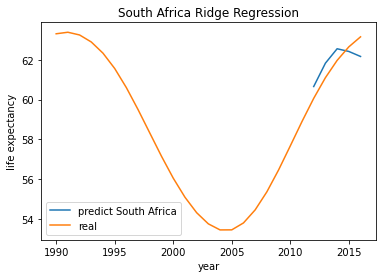

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

best mse: 0.41852393581818453 best alfa: 0.6579332246575682 



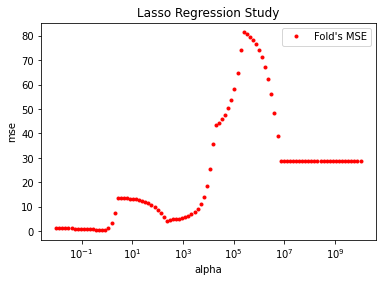

intrcpt :: 56.530891304
   YEAR :: -0.000000000
LIFE_EXPECTANCY :: 0.000007950
CO2_EMISSIONS :: 0.000284855
GDP_PER_CAPITA :: 0.000000000
BMI_MALE :: -0.000000000
BMI_FEMALE :: -0.000001409
TOTAL_POPULATION :: -0.000000000
RURAL_POPULATION :: -0.000000000
DRUG_USE_DISORDERS_y :: 0.038205705
ALCOHOL_USE_DISORDERS_y :: -0.000761499
TOBACCO :: -0.000042177
U5_DEATHS :: 0.000001349
URBAN_POPULATION :: -0.000000000
OBESITY_PERCENTAGE :: 0.000000000
R2: 0.6568140773897602


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


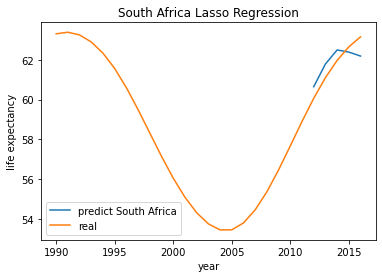

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

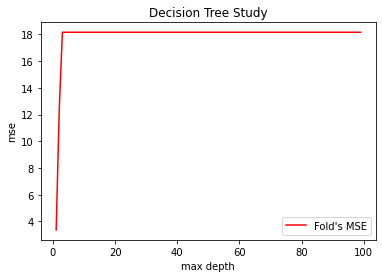

best tree: max_depth = 1
R2: -1.7594050196709219


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


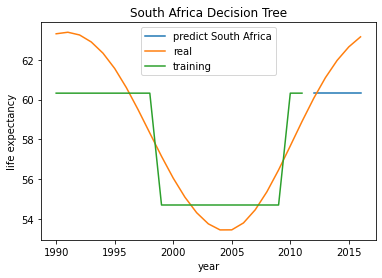

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

best tree: max_features = 5
mse:  10.903468464879474


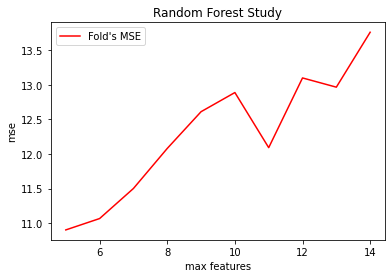

R2: -7.940747624042427


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


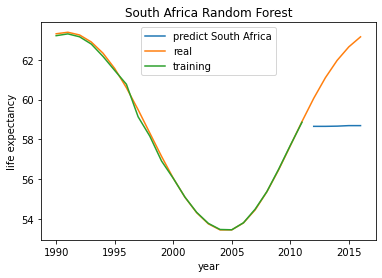

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

best GB: learning rate = 1.8


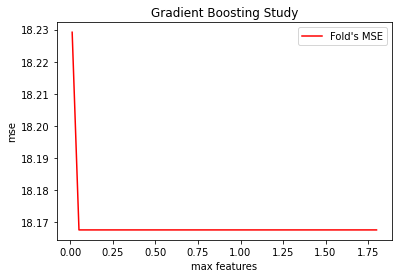

R2: -13.89724461313664


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:615: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


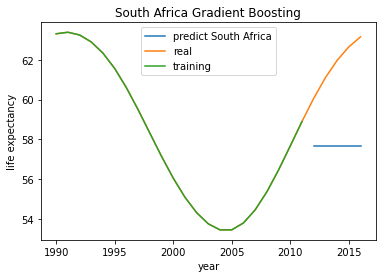

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_20848/1447653583.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [13]:
def choose_countries(df,list_country):
    
    data = df[df['COUNTRY_NAME']==list_country[0]]
    i=0 
    for country in list_country:
        if i>0:
            df1 = df[df['COUNTRY_NAME']==country] #australia #Brazil
            data = pd.concat([data,df1])
        i+=1
    return data
        



def pipeline(df,list_country,year):
    df1=choose_countries(df,list_country )
    

    df1 = df[df['COUNTRY_NAME']==list_country[0]] #australia #Brazil
    #df1 = df.loc[idx]
    df1=df1.dropna(axis=1)

    df1 = pd.get_dummies(df1, columns=['COUNTRY_NAME'])
     
    

    #excluded = [x for x in df.columns if x not in df1.columns]
    #print(excluded)
    
#     neural_network(df1,list_country,year)
    

    df2=reg_lin(df1,list_country,year)  
    df3=ridge(df1,list_country,year)
    df4=lasso(df1,list_country,year)
    df5=decision_tree(df1,list_country,year)
    df6=random_forest(df1,list_country,year)
 
    
    df7=gradient_boosting(df1,list_country,year)

    df_resultados = pd.concat([df2,df3,df4,df5,df6,df7])
    
    df_resultados.columns = df_resultados.columns.str.lstrip('COUNTRY_NAME_')
    
    
    df_resultados['Location'] = df_resultados[list_country].idxmax(1)

    df_resultados.drop(list_country,axis=1,inplace=True)
    df_resultados = df_resultados.rename(columns={'':'year'})  
    
 
    return df_resultados

list_country = [['Brazil'],['South Africa']]#,['United States'],['Portugal'],['South Africa'],['Switzerland']]
year = 2011

df_resultados = []

i=0
for country in list_country:
    
    if i ==0:
        df_resultados = pipeline(df,country,year)
    else:
        df_apoio = pipeline(df,country,year)
 
        df_resultados = pd.concat([df_resultados,df_apoio])
    
    i+=1
df_apoio
#create_table(df=df_resultados,tablename='results',conn=conn )

# If you're saving to a database
# create_table(df=df_resultados, tablename='results', conn=conn)

# If you want to save to CSV
df_resultados.to_csv('../data/processed/modeling_results.csv', index=False)
